In [1]:
from pykrx import stock
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

Loading BokehJS ...

### 참고 링크
* [참고 영상: Backtesting.py SMA Crossover Strategy Example with Bitcoin: Using Python to Optimize Parameters](https://youtu.be/gdrSo1Yclys)  
* [PyKrx](https://github.com/sharebook-kr/pykrx)

In [2]:
symbol = '040160' # 누리플랙스
df = stock.get_market_ohlcv("20190101", "20220124", symbol)

In [3]:
df.rename(columns={
    '시가': 'Open',
    '고가': 'High',
    '저가': 'Low',
    '종가': 'Close',
    '거래량': 'Volume'
    }, inplace=True)

In [11]:
df.head()

,Open,High,Low,Close,Volume
날짜,,,,,
2019-01-02,5690,5720,5630,5680,23107
2019-01-03,5700,5790,5540,5580,21049
2019-01-04,5650,5710,5470,5580,21985
2019-01-07,5600,5740,5570,5720,19438
2019-01-08,5730,5740,5540,5680,16914


In [4]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data['Close']
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            #self.sell()


In [5]:
bt = Backtest(df, SmaCross,
              cash=1000000, commission=.002,
              exclusive_orders=True)

output = bt.run()

In [6]:
bt.plot()

Row(id='1450', ...)

In [15]:
output

Start                     2019-01-02 00:00:00
End                       2022-01-24 00:00:00
Duration                   1118 days 00:00:00
Exposure Time [%]                    91.82058
Equity Final [$]                     417785.0
Equity Peak [$]                    1805795.32
Return [%]                           -58.2215
Buy & Hold Return [%]               37.676056
Return (Ann.) [%]                  -25.185751
Volatility (Ann.) [%]               38.063519
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -77.42784
Avg. Drawdown [%]                   -12.60138
Max. Drawdown Duration      602 days 00:00:00
Avg. Drawdown Duration       67 days 00:00:00
# Trades                                   39
Win Rate [%]                        41.025641
Best Trade [%]                       26.77348
Worst Trade [%]                    -40.087337
Avg. Trade [%]                    

In [10]:
stats, heatmap = bt.optimize(n1=range(5, 120, 5), n2=range(20, 220, 5), 
    maximize='Equity Final [$]',
    constraint=lambda param: param.n1 < param.n2, return_heatmap=True
    )
print(f'stats={stats}')
print(f'stats._strategy={stats._strategy}')
bt.plot()


stats=Start                     2019-01-02 00:00:00
End                       2022-01-24 00:00:00
Duration                   1118 days 00:00:00
Exposure Time [%]                   48.548813
Equity Final [$]                   1530920.04
Equity Peak [$]                    1886730.04
Return [%]                          53.092004
Buy & Hold Return [%]               37.676056
Return (Ann.) [%]                   15.209467
Volatility (Ann.) [%]               45.518529
Sharpe Ratio                         0.334138
Sortino Ratio                        0.740455
Calmar Ratio                         0.417417
Max. Drawdown [%]                  -36.437115
Avg. Drawdown [%]                   -9.387774
Max. Drawdown Duration      207 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      53.253364
Worst Trade [%]                     53.253364
Avg. Trade [%]              

Row(id='2182', ...)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

heatmap=n1   n2 
105  185    1530920.04
110  185    1496788.14
105  190    1483066.04
     200    1462526.04
110  190    1430929.20
105  195    1427676.48
95   195    1424146.38
115  205    1421440.04
     185    1420178.14
95   190    1416850.88
Name: Equity Final [$], dtype: float64


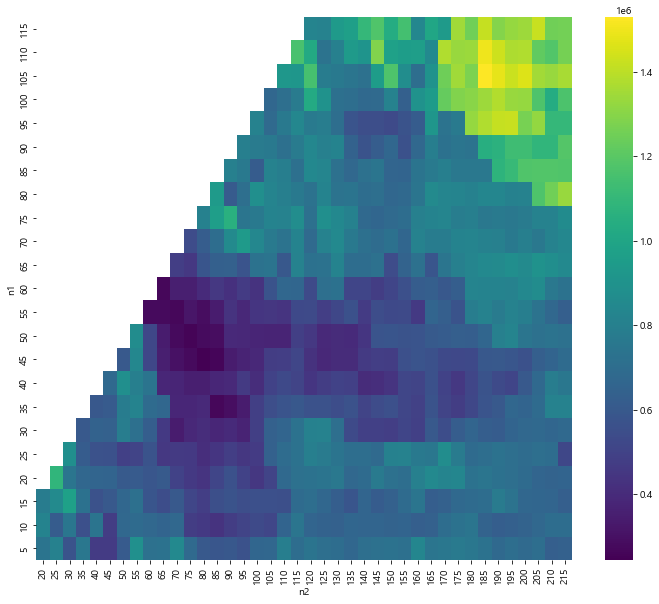

In [13]:
print(f'heatmap={heatmap.sort_values(ascending=False).iloc[:10]}')
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')
plt.savefig('sma-crossover-heapmap.png')